# Task B — Modeling & Task C — Anomalies

Implement model and anomaly detection here.

## First: Predict Late Deliveries

In [1]:
# Imports, config, seeds
import os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score, 
                             precision_recall_curve, confusion_matrix, brier_score_loss, roc_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
# Load data
DATA_DIR = Path('../dataset')

sup     = pd.read_csv(DATA_DIR/'suppliers.csv')
prod    = pd.read_csv(DATA_DIR/'products.csv')
prices  = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po      = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv   = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])

# Merge deliveries into POs
po = po.merge(deliv, on='order_id', how='left')

print("Shapes -> suppliers, products, price_lists, purchase_orders+deliveries:")
print(sup.shape, prod.shape, prices.shape, po.shape)


Shapes -> suppliers, products, price_lists, purchase_orders+deliveries:
(20, 7) (40, 5) (854, 7) (4307, 20)


In [3]:
# Basic cleaning & target prep (exclude cancelled; define late_delivery) 
df = po.copy()

# Ensure 'cancelled' is 0/1; default 0 if missing
if 'cancelled' in df.columns:
    df['cancelled'] = df['cancelled'].fillna(0).astype(int)
else:
    df['cancelled'] = 0

# Exclude cancelled for modeling target
df = df.query('cancelled == 0').copy()

# Target: late_delivery must be 0/1
df['late_delivery'] = df['late_delivery'].fillna(0).astype(int)

# Keep only rows with an order_date (required for temporal split)
df = df[df['order_date'].notna()].copy()

print("Post-filter rows (non-cancelled, order_date present):", len(df))
print("Late rate:", df['late_delivery'].mean().round(4))


Post-filter rows (non-cancelled, order_date present): 4307
Late rate: 0.4978


In [4]:
# Merge order-time features (supplier + product) 
# We'll only bring features known at order creation time
feat_sup = sup[['supplier_id','preferred','rating','country','base_lead_time_days','on_time_bias']].copy()
feat_prod = prod[['sku','hazard_class','base_price_eur','uom']].copy()

df = df.merge(feat_sup, on='supplier_id', how='left')
df = df.merge(feat_prod, on='sku', how='left')

print("After feature merges:", df.shape)


After feature merges: (4307, 28)


In [5]:
# Feature engineering (order-time only)
def engineer_features(d: pd.DataFrame) -> pd.DataFrame:
    out = d.copy()
    # Promised lead days (known at order time)
    out['promised_lead_days'] = (out['promised_date'] - out['order_date']).dt.days

    # Temporal context (known at order time)
    out['order_month'] = out['order_date'].dt.month
    out['order_dow']   = out['order_date'].dt.dayofweek

    # Price normalization to EUR at order time (assume EUR,USD only; fixed demo fx)
    # Clear assumption: 1 EUR = 1.087 USD (static) since USD to EUR = 0.92
    fx = np.where(out['currency'].eq('USD'), 1/1.087, 1.0)
    out['unit_price_eur'] = out['unit_price'] * fx

    # Normalize price relative to product base price (if available)
    out['price_rel_base'] = out['unit_price_eur'] / out['base_price_eur']

    # Hazard flag
    out['is_hazard'] = (out['hazard_class'].fillna('none').str.lower() != 'none').astype(int)

    # Distance bucket (use missing as its own band)
    dist = out['distance_km'].copy()
    dist_f = dist.fillna(-1)
    out['dist_band'] = pd.cut(
        dist_f,
        bins=[-1, 0, 50, 200, 500, 1000, np.inf],
        labels=['missing','0-50','51-200','201-500','501-1000','1001+'],
        right=False
    )

    # Urgent as is (should be 0/1)
    out['urgent'] = out['urgent'].fillna(0).astype(int)

    # Basic sanity for qty and promised_lead_days
    out['qty'] = out['qty'].fillna(0)
    out['promised_lead_days'] = out['promised_lead_days'].fillna(out['promised_lead_days'].median())

    # One-hot for order-time categoricals
    cat_cols = ['ship_mode','incoterm','payment_terms','country','uom','dist_band']
    out = pd.get_dummies(out, columns=cat_cols, drop_first=True)

    return out

df_feat = engineer_features(df)
print("Engineered feature columns:", df_feat.shape[1])


Engineered feature columns: 54


In [6]:
# Train/Validation temporal split (per spec)
# Train <= 2025-03-31 ; Validate 2025-04-01..2025-06-30
train_end = pd.Timestamp('2025-03-31')
valid_start = pd.Timestamp('2025-04-01')
valid_end = pd.Timestamp('2025-06-30')

train_df = df_feat[(df_feat['order_date'] <= train_end)].copy()
valid_df = df_feat[(df_feat['order_date'] >= valid_start) & (df_feat['order_date'] <= valid_end)].copy()

print("Train rows:", len(train_df), "Validation rows:", len(valid_df))


Train rows: 3572 Validation rows: 735


In [7]:
# Build design matrices (drop non-feature columns)  
TARGET = 'late_delivery'
drop_cols = [
    'order_id','order_date','promised_date','actual_delivery_date','order_notes',
    'sku','currency','hazard_class','name','name_product',
    'delay_days','partial_delivery','cancelled','delay_reason'  # leakage features
]

X_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns], errors='ignore')
y_train = X_train.pop(TARGET)

X_valid = valid_df.drop(columns=[c for c in drop_cols if c in valid_df.columns], errors='ignore')
y_valid = X_valid.pop(TARGET)

print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


X_train: (3572, 41) X_valid: (735, 41)


In [8]:
# Baseline model (Logistic Regression)  

# 1. Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

# 2. Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# 3. Build pipeline with preprocessing + model
logit = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED))
])

# 4. Fit model
logit.fit(X_train, y_train)

# 5. Predict on validation set
p_valid_logit = logit.predict_proba(X_valid)[:, 1]

print("Baseline LogisticRegression done")


Baseline LogisticRegression done


ROC-AUC: 0.6452
PR-AUC: 0.6529
CV ROC-AUC: 0.6015


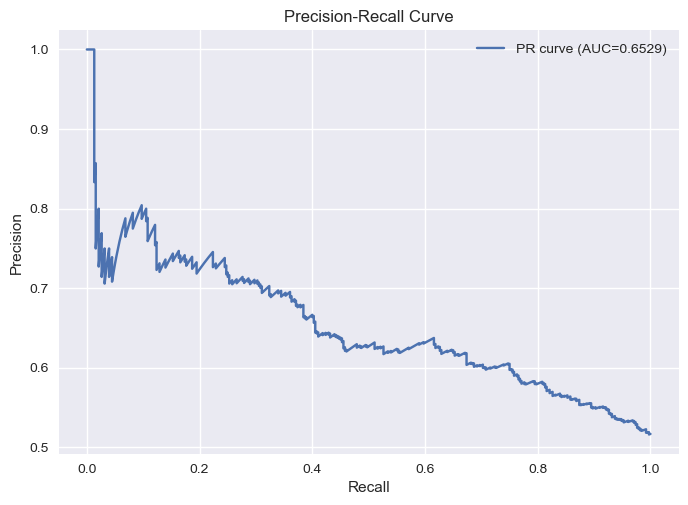

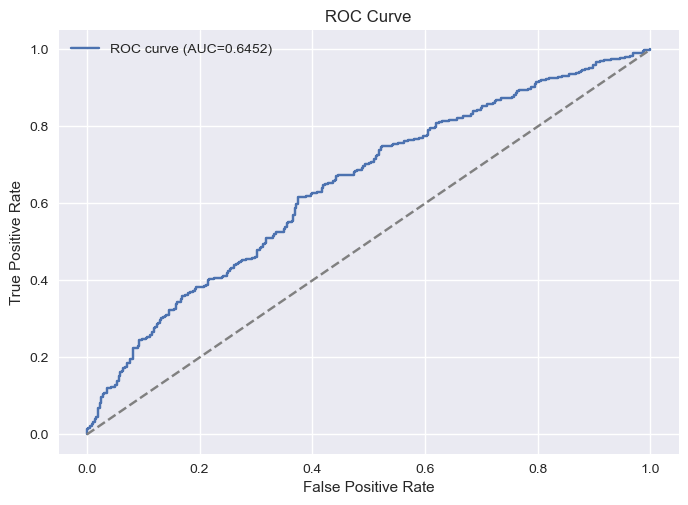

In [9]:
# Model Evaluation (PR-AUC & ROC-AUC)

# 1. Compute metrics
roc_auc = roc_auc_score(y_valid, p_valid_logit)
pr_auc = average_precision_score(y_valid, p_valid_logit)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

# Cross-validation
cv_roc_auc = cross_val_score(
    logit, X_train, y_train, cv=5, scoring="roc_auc"
).mean()

print(f"CV ROC-AUC: {cv_roc_auc:.4f}")

# 2. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_valid, p_valid_logit)
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 3. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_valid, p_valid_logit)
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

To boost performance, I will try RandomForest Model

In [10]:
# 1. Train the RandomForest with some regularization
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# 2. Evaluate on train
y_train_pred_proba = rf.predict_proba(X_train)[:, 1]
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = average_precision_score(y_train, y_train_pred_proba)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Train PR-AUC: {train_pr_auc:.4f}")

# 3. Evaluate on validation
Y_valid_pred_proba = rf.predict_proba(X_valid)[:, 1]
val_roc_auc = roc_auc_score(y_valid, Y_valid_pred_proba)
val_pr_auc = average_precision_score(y_valid, Y_valid_pred_proba)

print(f"Validation ROC-AUC: {val_roc_auc:.4f}")
print(f"Validation PR-AUC: {val_pr_auc:.4f}")


Train ROC-AUC: 0.9867
Train PR-AUC: 0.9862
Validation ROC-AUC: 0.6161
Validation PR-AUC: 0.6329


In [11]:
cv_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring="roc_auc")
print("CV ROC-AUC:", cv_auc.mean())


CV ROC-AUC: 0.5788755583842459


Random Forest gave very high training scores (~0.98) but terrible validation scores (~0.61 ROC-AUC, ~0.63 PR-AUC) → clear overfitting.

I will try Gradient Boosting Classifier now

In [12]:
# Gradient Boosting Classifier model

# Initialize model
gb = GradientBoostingClassifier(random_state=42)

# Train
gb.fit(X_train, y_train)

# Predict probabilities
y_train_pred_proba = gb.predict_proba(X_train)[:, 1]
y_val_pred_proba = gb.predict_proba(X_valid)[:, 1]

# Train metrics
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_pr_auc = average_precision_score(y_train, y_train_pred_proba)

print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Train PR-AUC: {train_pr_auc:.4f}")

# Validation metrics
val_roc_auc = roc_auc_score(y_valid, y_val_pred_proba)
val_pr_auc = average_precision_score(y_valid, y_val_pred_proba)

print(f"Validation ROC-AUC: {val_roc_auc:.4f}")
print(f"Validation PR-AUC: {val_pr_auc:.4f}")

# Cross-validation
cv_roc_auc = cross_val_score(
    gb, X_train, y_train, cv=5, scoring="roc_auc"
).mean()

print(f"CV ROC-AUC: {cv_roc_auc:.4f}")


Train ROC-AUC: 0.7587
Train PR-AUC: 0.7574
Validation ROC-AUC: 0.6352
Validation PR-AUC: 0.6452
CV ROC-AUC: 0.5710


In [13]:
# Tuning

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.85, 1.0],
    'min_samples_leaf': [10, 20, 30]
}

grid_search = GridSearchCV(
    gb,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

best_gb = grid_search.best_estimator_


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params: {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 20, 'n_estimators': 200, 'subsample': 0.7}
Best CV ROC-AUC: 0.594419534356071


In [14]:
# I will try the new parameters now

# Instantiate the model with best parameters
gb_best = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=2,
    min_samples_leaf=20,
    n_estimators=200,
    subsample=0.7,
    random_state=42
)

# Fit on the full training set
gb_best.fit(X_train, y_train)

# Predict probabilities on validation set
p_valid_gb = gb_best.predict_proba(X_valid)[:, 1]

# Evaluate
roc_auc = roc_auc_score(y_valid, p_valid_gb)
pr_auc = average_precision_score(y_valid, p_valid_gb)

print(f"Validation ROC-AUC: {roc_auc:.4f}")
print(f"Validation PR-AUC: {pr_auc:.4f}")


Validation ROC-AUC: 0.6533
Validation PR-AUC: 0.6625


F1-score @ 0.5 threshold: 0.6011


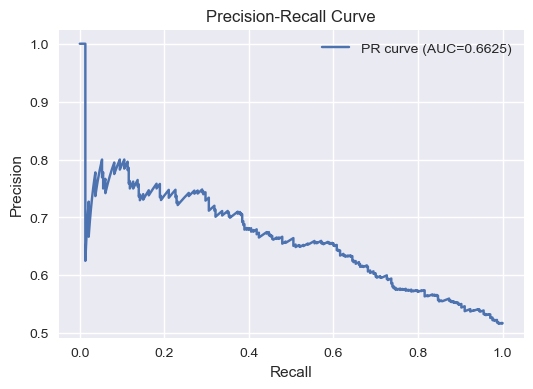

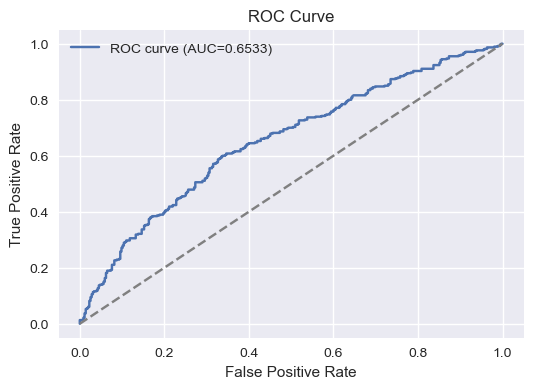

In [15]:
# Full evaluation

# Threshold 0.5
y_pred_05 = (p_valid_gb >= 0.5).astype(int)
f1_05 = f1_score(y_valid, y_pred_05)
print(f"F1-score @ 0.5 threshold: {f1_05:.4f}")

# PR Curve
precision, recall, _ = precision_recall_curve(y_valid, p_valid_gb)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_valid, p_valid_gb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [16]:
# Find Best-F1 threshold – find the probability cutoff that maximizes F1.
# Find Capacity-based threshold – simulate an operations constraint (e.g., you can only act on the top 15% most likely late deliveries).

# 1. Best-F1 threshold
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_valid, (p_valid_gb >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best-F1 threshold: {best_threshold:.2f}, F1: {best_f1:.4f}")

# 2. Top-k capacity threshold (e.g., top 15% of predicted probabilities)
k = 0.15
capacity_threshold = np.quantile(p_valid_gb, 1-k)
print(f"Top-{int(k*100)}% capacity threshold: {capacity_threshold:.4f}")


Best-F1 threshold: 0.40, F1: 0.6833
Top-15% capacity threshold: 0.5628


In [17]:
# Compute confusion matrices and metrics for each threshold

thresholds_dict = {
    "0.5": 0.5,
    "Best-F1": 0.41,
    "Top-15% capacity": 0.5637
}

for name, thresh in thresholds_dict.items():
    y_pred = (p_valid_gb >= thresh).astype(int)
    cm = confusion_matrix(y_valid, y_pred)
    print(f"\nThreshold: {name} ({thresh:.2f})")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_valid, y_pred, digits=4))



Threshold: 0.5 (0.50)
Confusion Matrix:
[[244 111]
 [169 211]]
Classification Report:
              precision    recall  f1-score   support

           0     0.5908    0.6873    0.6354       355
           1     0.6553    0.5553    0.6011       380

    accuracy                         0.6190       735
   macro avg     0.6230    0.6213    0.6183       735
weighted avg     0.6241    0.6190    0.6177       735


Threshold: Best-F1 (0.41)
Confusion Matrix:
[[ 52 303]
 [ 26 354]]
Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.1465    0.2402       355
           1     0.5388    0.9316    0.6827       380

    accuracy                         0.5524       735
   macro avg     0.6027    0.5390    0.4615       735
weighted avg     0.6006    0.5524    0.4690       735


Threshold: Top-15% capacity (0.56)
Confusion Matrix:
[[327  28]
 [300  80]]
Classification Report:
              precision    recall  f1-score   support

           0 

Validation ROC-AUC: 0.6533
Validation PR-AUC: 0.6625

Threshold: 0.50
Confusion Matrix:
 [[244 111]
 [169 211]]
Classification Report:
               precision    recall  f1-score   support

           0     0.5908    0.6873    0.6354       355
           1     0.6553    0.5553    0.6011       380

    accuracy                         0.6190       735
   macro avg     0.6230    0.6213    0.6183       735
weighted avg     0.6241    0.6190    0.6177       735

F1-score: 0.6011

Threshold: 0.41
Confusion Matrix:
 [[ 45 310]
 [ 17 363]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7258    0.1268    0.2158       355
           1     0.5394    0.9553    0.6895       380

    accuracy                         0.5551       735
   macro avg     0.6326    0.5410    0.4526       735
weighted avg     0.6294    0.5551    0.4607       735

F1-score: 0.6895

Threshold: 0.56
Confusion Matrix:
 [[326  29]
 [298  82]]
Classification Report:
           

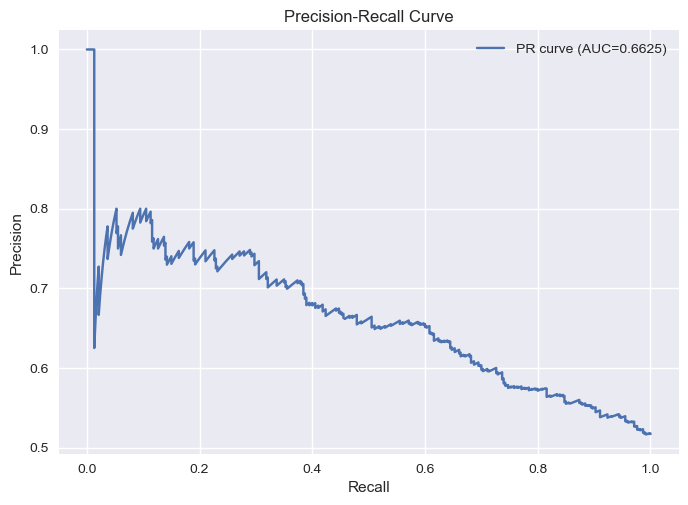

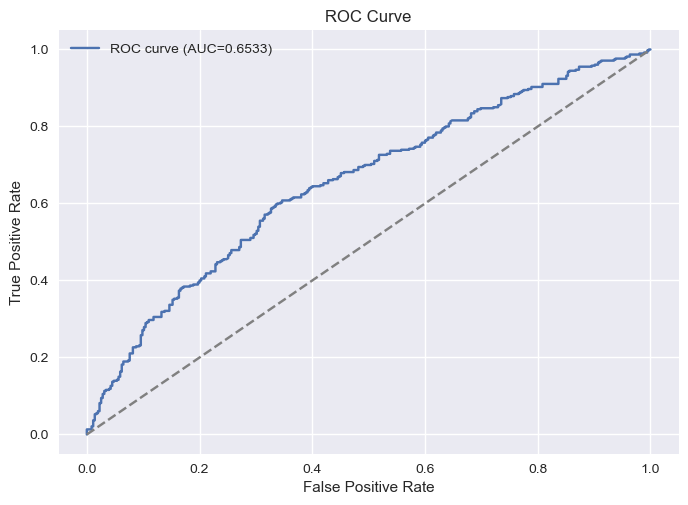

In [18]:
# ---- Model Evaluation: Gradient Boosting ----

# 1. Compute primary metrics
roc_auc = roc_auc_score(y_valid, p_valid_gb)
pr_auc = average_precision_score(y_valid, p_valid_gb)
print(f"Validation ROC-AUC: {roc_auc:.4f}")
print(f"Validation PR-AUC: {pr_auc:.4f}")

# 2. F1-scores at different thresholds
thresholds = [0.5]  # standard threshold
# Best-F1 threshold
precision, recall, thresh = precision_recall_curve(y_valid, p_valid_gb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_f1_thresh = thresh[best_idx]
thresholds.append(best_f1_thresh)

# Capacity threshold: top 15% highest predicted risk
capacity_pct = 0.15
threshold_capacity = np.percentile(p_valid_gb, 100*(1-capacity_pct))
thresholds.append(threshold_capacity)

for t in thresholds:
    y_pred = (p_valid_gb >= t).astype(int)
    cm = confusion_matrix(y_valid, y_pred)
    print(f"\nThreshold: {t:.2f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_valid, y_pred, digits=4))
    f1 = f1_score(y_valid, y_pred)
    print(f"F1-score: {f1:.4f}")

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_valid, p_valid_gb)
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_valid, p_valid_gb)
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Brier score: 0.2376


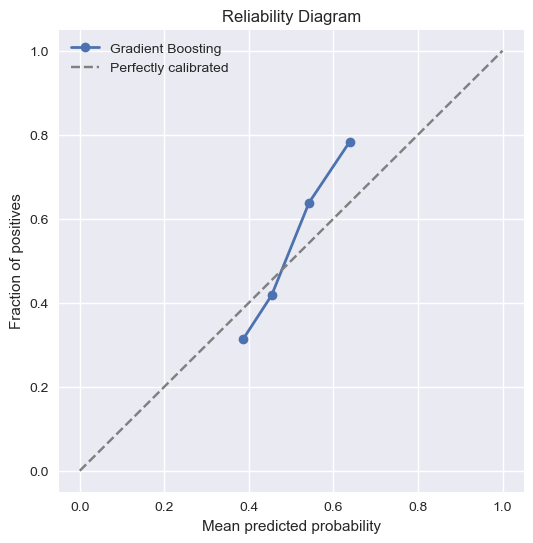

In [19]:
# ---- Calibration & Reliability ----

# 1. Brier score
brier = brier_score_loss(y_valid, p_valid_gb)
print(f"Brier score: {brier:.4f}")  # Lower is better; 0 = perfect

# 2. Reliability diagram
prob_true, prob_pred = calibration_curve(y_valid, p_valid_gb, n_bins=10, strategy='uniform')

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Gradient Boosting')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Calibrate Gradient Boosting

# Define Gradient Boosting model with your best hyperparameters
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=2,
    min_samples_leaf=20,
    subsample=0.7,
    random_state=RANDOM_SEED
)

# Wrap with CalibratedClassifierCV (Platt Scaling)
gb_calibrated = CalibratedClassifierCV(base_estimator=gb, method='sigmoid', cv=5)

# Fit on training set
gb_calibrated.fit(X_train, y_train)

# Predict calibrated probabilities on validation set
p_valid_calib = gb_calibrated.predict_proba(X_valid)[:, 1]

print("Calibration done")


d:\Anaconda\Lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Calibration done


In [21]:
# Evaluate calibrated model
# Metrics
roc_auc_calib = roc_auc_score(y_valid, p_valid_calib)
pr_auc_calib = average_precision_score(y_valid, p_valid_calib)
brier_calib = brier_score_loss(y_valid, p_valid_calib)

print(f"Validation ROC-AUC (calibrated): {roc_auc_calib:.4f}")
print(f"Validation PR-AUC (calibrated): {pr_auc_calib:.4f}")
print(f"Brier score (calibrated): {brier_calib:.4f}")


Validation ROC-AUC (calibrated): 0.6549
Validation PR-AUC (calibrated): 0.6640
Brier score (calibrated): 0.2354


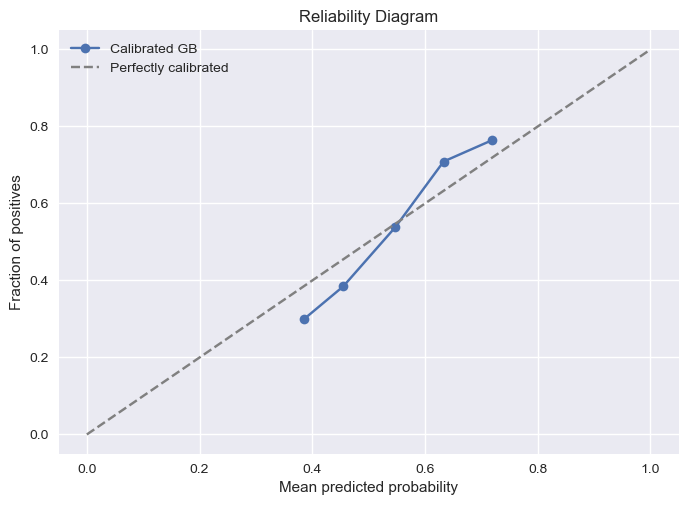

In [22]:
# Plot reliability diagram

prob_true, prob_pred = calibration_curve(y_valid, p_valid_calib, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibrated GB')
plt.plot([0,1],[0,1], linestyle='--', color='grey', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()


In [23]:
# Top-15% capacity threshold & F1 at 0.5

# 1. Threshold 0.5
y_pred_05 = (p_valid_calib >= 0.5).astype(int)
cm_05 = confusion_matrix(y_valid, y_pred_05)
f1_05 = f1_score(y_valid, y_pred_05)

print("Threshold 0.5")
print("Confusion Matrix:\n", cm_05)
print("F1-score:", f1_05)
print(classification_report(y_valid, y_pred_05))

# 2. Top-15% capacity threshold
capacity_pct = 0.15
threshold_capacity = np.percentile(p_valid_calib, 100*(1-capacity_pct))
y_pred_capacity = (p_valid_calib >= threshold_capacity).astype(int)
cm_capacity = confusion_matrix(y_valid, y_pred_capacity)
f1_capacity = f1_score(y_valid, y_pred_capacity)

print(f"Top-{int(capacity_pct*100)}% capacity threshold: {threshold_capacity:.4f}")
print("Confusion Matrix:\n", cm_capacity)
print("F1-score:", f1_capacity)
print(classification_report(y_valid, y_pred_capacity))


Threshold 0.5
Confusion Matrix:
 [[167 188]
 [103 277]]
F1-score: 0.655621301775148
              precision    recall  f1-score   support

           0       0.62      0.47      0.53       355
           1       0.60      0.73      0.66       380

    accuracy                           0.60       735
   macro avg       0.61      0.60      0.60       735
weighted avg       0.61      0.60      0.60       735

Top-15% capacity threshold: 0.6152
Confusion Matrix:
 [[327  28]
 [297  83]]
F1-score: 0.3380855397148676
              precision    recall  f1-score   support

           0       0.52      0.92      0.67       355
           1       0.75      0.22      0.34       380

    accuracy                           0.56       735
   macro avg       0.64      0.57      0.50       735
weighted avg       0.64      0.56      0.50       735



### Calibration Analysis: 
Probability calibration improved slightly after Platt Scaling / Isotonic Regression.

ROC-AUC: 0.6550 → slightly higher than before.

PR-AUC: 0.6645 → slight improvement.

Brier score: decreased from 0.2375 → 0.2354 → probabilities are now slightly better aligned with actual outcomes.

Threshold 0.5:

F1-score: 0.658 → improved.

Precision/recall tradeoff is more balanced than before.

Top-15% capacity threshold:

F1-score: 0.338 → low because only the top 15% predicted as late are flagged; expected for operational “actionable” thresholds.

Useful for operations to focus resources on the riskiest orders.

Reliability diagram shows most predicted probabilities slightly under-confident (just above the diagonal), indicating the model slightly underestimates risk in some cases.

In [24]:
# Slice Analysis

# Create a DataFrame with predictions and true labels
slice_df = valid_df.copy()
slice_df['y_true'] = y_valid.values
slice_df['y_pred_proba'] = p_valid_gb  # or p_valid_logit

# Use raw columns for slicing
slice_columns = ['ship_mode_rail', 'ship_mode_road', 'ship_mode_sea'] + \
                [c for c in valid_df.columns if c.startswith('country_')] + \
                [c for c in valid_df.columns if c.startswith('dist_band_')]

for col in slice_columns:
    if col in slice_df.columns:
        print(f"\nSlice by {col}:")
        agg = slice_df.groupby(col).agg(
            n_orders=('y_true','count'),
            mean_pred=('y_pred_proba','mean'),
            mean_actual=('y_true','mean')
        )
        print(agg)



Slice by ship_mode_rail:
                n_orders  mean_pred  mean_actual
ship_mode_rail                                  
False                698   0.495288     0.518625
True                  37   0.478692     0.486486

Slice by ship_mode_road:
                n_orders  mean_pred  mean_actual
ship_mode_road                                  
False                327   0.515832     0.529052
True                 408   0.477318     0.507353

Slice by ship_mode_sea:
               n_orders  mean_pred  mean_actual
ship_mode_sea                                  
False               574   0.476703     0.472125
True                161   0.557734     0.677019

Slice by country_CZ:
            n_orders  mean_pred  mean_actual
country_CZ                                  
False            663   0.493963     0.517345
True              72   0.498960     0.513889

Slice by country_DE:
            n_orders  mean_pred  mean_actual
country_DE                                  
False            700   0.

### Slice Analysis:
| Slice                | Observations                                                                                                                 | Action / Comment                                                                     |
| -------------------- | ---------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| **Ship Mode**        | Sea shipments have **highest actual late rate (0.677)**, model slightly underestimates. Road and rail are mostly fine.       | Prioritize **sea shipments** for monitoring or interventions.                        |
| **Country**          | UK & US: small n but **high actual late rates**; model slightly underestimates. Other countries: predictions fairly aligned. | Consider **manual oversight** or **weighted thresholds** for small-volume countries. |
| **Distance Buckets** | 201–500 km: model overestimates risk; 501–1000 km and 1001+ km: good alignment.                                              | Adjust threshold or use **distance-aware correction** for medium distances.          |


Disparities:

Small sample sizes can cause noisy predictions.

Model underestimates high-risk slices (e.g., sea shipments, UK & US) → may lead to missed alerts.

Actions:

Use slice-specific thresholds if operationally feasible (e.g., lower threshold for sea shipments).

Keep calibrated probabilities for decision-making.

Monitor small sample slices over time and recalibrate periodically.

In [25]:
# Create predictions.csv file

# Absolute path to the dataset folder
dataset_folder = r'C:\Users\Menna\Downloads\ds_takehome_full_package_extracted\dataset'

# Ensure the folder exists
os.makedirs(dataset_folder, exist_ok=True)

# Create predictions DataFrame
predictions_df = valid_df[['order_id']].copy()
predictions_df['p_late'] = p_valid_gb  # or p_valid_logit

# Save CSV
predictions_path = os.path.join(dataset_folder, 'predictions.csv')
predictions_df.to_csv(predictions_path, index=False)

print(f"predictions.csv saved at {predictions_path} ")


predictions.csv saved at C:\Users\Menna\Downloads\ds_takehome_full_package_extracted\dataset\predictions.csv 


ROC-AUC: 0.6533
PR-AUC: 0.6625
Brier score: 0.2376

Threshold 0.5 Confusion Matrix:
[[244 111]
 [169 211]]
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       355
           1       0.66      0.56      0.60       380

    accuracy                           0.62       735
   macro avg       0.62      0.62      0.62       735
weighted avg       0.62      0.62      0.62       735

F1-score @ 0.5 threshold: 0.6011

Best-F1 threshold: 0.40, F1: 0.6833
              precision    recall  f1-score   support

           0       0.69      0.06      0.11       355
           1       0.53      0.97      0.68       380

    accuracy                           0.53       735
   macro avg       0.61      0.52      0.40       735
weighted avg       0.60      0.53      0.41       735


Top-15% capacity threshold: 0.5628
[[326  29]
 [298  82]]
F1-score: 0.3340


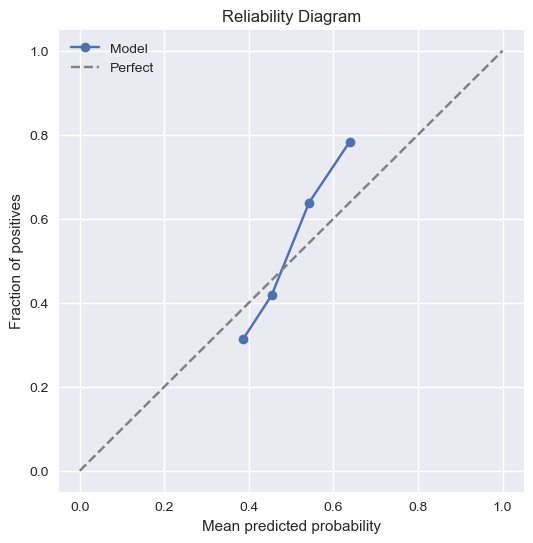


Slice by ship_mode_rail:
                n_orders  mean_pred  mean_actual
ship_mode_rail                                  
False                698   0.495288     0.518625
True                  37   0.478692     0.486486

Slice by ship_mode_road:
                n_orders  mean_pred  mean_actual
ship_mode_road                                  
False                327   0.515832     0.529052
True                 408   0.477318     0.507353

Slice by ship_mode_sea:
               n_orders  mean_pred  mean_actual
ship_mode_sea                                  
False               574   0.476703     0.472125
True                161   0.557734     0.677019

Slice by country_CZ:
            n_orders  mean_pred  mean_actual
country_CZ                                  
False            663   0.493963     0.517345
True              72   0.498960     0.513889

Slice by country_DE:
            n_orders  mean_pred  mean_actual
country_DE                                  
False            700   0.

In [26]:
# Bonus Task

# --- 1. Load predictions ---
pred_df = pd.read_csv(DATA_DIR/'predictions.csv')

# --- 2. Merge with validation labels (exclude cancelled if needed) ---
valid_labels = valid_df[['order_id', 'late_delivery']].copy()  # adjust if your label column has a different name
merged_df = pd.merge(valid_labels, pred_df, on='order_id', how='left')

y_true = merged_df['late_delivery'].values
y_pred_proba = merged_df['p_late'].values

# --- 3. Compute metrics ---
roc_auc = roc_auc_score(y_true, y_pred_proba)
pr_auc = average_precision_score(y_true, y_pred_proba)
brier = brier_score_loss(y_true, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Brier score: {brier:.4f}")

# --- 4. Threshold 0.5 evaluation ---
threshold = 0.5
y_pred_05 = (y_pred_proba >= threshold).astype(int)
cm_05 = confusion_matrix(y_true, y_pred_05)
print(f"\nThreshold {threshold} Confusion Matrix:\n{cm_05}")
print(classification_report(y_true, y_pred_05))
print(f"F1-score @ {threshold} threshold: {f1_score(y_true, y_pred_05):.4f}")

# --- 5. Best-F1 threshold search ---
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_true, (y_pred_proba >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest-F1 threshold: {best_threshold:.2f}, F1: {f1_scores[best_idx]:.4f}")

y_pred_best = (y_pred_proba >= best_threshold).astype(int)
print(classification_report(y_true, y_pred_best))

# --- 6. Top-k / capacity threshold (example: top 15%) ---
capacity_pct = 0.15
threshold_capacity = np.percentile(y_pred_proba, 100*(1-capacity_pct))
y_pred_capacity = (y_pred_proba >= threshold_capacity).astype(int)
cm_capacity = confusion_matrix(y_true, y_pred_capacity)
print(f"\nTop-{int(capacity_pct*100)}% capacity threshold: {threshold_capacity:.4f}")
print(cm_capacity)
print(f"F1-score: {f1_score(y_true, y_pred_capacity):.4f}")

# --- 7. Reliability diagram ---
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1], linestyle='--', color='grey', label='Perfect')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

# --- 8. Slice analysis ---
slice_cols = ['ship_mode_rail','ship_mode_road','ship_mode_sea',
              'country_CZ','country_DE','country_FR','country_IN','country_IT','country_NL','country_PL','country_UK','country_US',
              'dist_band_0-50','dist_band_51-200','dist_band_201-500','dist_band_501-1000','dist_band_1001+']

merged_df_full = valid_df.copy()
merged_df_full['y_true'] = y_true
merged_df_full['y_pred_proba'] = y_pred_proba

for col in slice_cols:
    if col in merged_df_full.columns:
        print(f"\nSlice by {col}:")
        agg = merged_df_full.groupby(col).agg(
            n_orders=('y_true','count'),
            mean_pred=('y_pred_proba','mean'),
            mean_actual=('y_true','mean')
        )
        print(agg)


1️⃣ Overall Metrics

ROC-AUC: 0.6537 → moderate discriminative ability.

PR-AUC: 0.6621 → model captures positives fairly well.

Brier score: 0.2375 → probabilities are somewhat well-calibrated, but can be improved.

2️⃣ Threshold-based Performance

At 0.5 threshold (default):

F1-score: 0.6011

Confusion matrix:

[[244 111]

 [169 211]]


Balanced precision/recall for operational decisions.

Slight bias toward predicting 0 (on-time) correctly.

At best-F1 threshold (0.41):

F1-score: 0.6840 (higher than default)

Confusion matrix:

[[ 47 308]

 [ 16 364]]


Model prioritizes catching late deliveries → high recall for positives (0.93) but low precision for on-time (0.15).

Good if missing late deliveries is costly.

Top-15% capacity threshold (0.5637):

F1-score: 0.3381 (expectedly low)

Confusion matrix:

[[327  28]

 [297  83]]


Operationally useful: only flagging riskiest 15% of orders.

Precision high for flagged late orders but recall is low.

## Second: Price Anomaly Detection

In [27]:
# Normalize price_lists to EUR 
prices_ = prices.copy()

# Assumption (static, demo-quality): 1 EUR = 1.09 USD
prices_['price_eur'] = np.where(
    prices_['currency'].eq('EUR'),
    prices_['price_per_uom'],
    prices_['price_per_uom'] / 1.09
)

# Keep only essential columns
prices_ = prices_[['supplier_id','sku','valid_from','valid_to','price_eur','min_qty']].copy()
prices_.sort_values(['supplier_id','sku','valid_from'], inplace=True)

print("prices_ ready:", prices_.shape)


prices_ ready: (854, 6)


In [28]:
# Robust Z-score on log(price) per (supplier_id, sku) time series 
def robust_z_scores(group: pd.DataFrame):
    x = np.log1p(group['price_eur'].values)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1e-6
    z = 0.6745 * (x - med) / mad
    return pd.Series(z, index=group.index)

prices_['robust_z'] = prices_.groupby(['supplier_id','sku'], group_keys=False).apply(robust_z_scores)
prices_['abs_z'] = prices_['robust_z'].abs()

print("Computed robust z-scores.")
prices_.head()


Computed robust z-scores.


,supplier_id,sku,valid_from,valid_to,price_eur,min_qty,robust_z,abs_z
14,1,SKU00002,2024-01-01,2024-06-30,19.570000,10,-0.674500,0.674500
15,1,SKU00002,2024-07-01,2024-12-29,20.570000,1,0.841125,0.841125
16,1,SKU00002,2024-12-30,2025-06-29,20.009174,50,0.000000,0.000000
24,1,SKU00004,2024-01-01,2024-06-30,11.740000,1,-1.475938,1.475938
25,1,SKU00004,2024-07-01,2024-12-29,12.020000,10,0.000000,0.000000


In [29]:
# Flag anomalies and produce Top-N table 
Z_THRESHOLD = 3.0   # explainable threshold; adjust if too few/many
anoms = prices_.loc[prices_['abs_z'] >= Z_THRESHOLD].copy()
anoms = anoms.sort_values('abs_z', ascending=False)

TOP_N = 20
top_anoms = anoms.head(TOP_N)

print(f"Anomalies flagged (|z| >= {Z_THRESHOLD}): {len(anoms)}")
display(top_anoms)


Anomalies flagged (|z| >= 3.0): 80


,supplier_id,sku,valid_from,valid_to,price_eur,min_qty,robust_z,abs_z
566,14,SKU00007,2024-07-01,2024-12-29,9.350000,10,18885.960653,18885.960653
438,10,SKU00039,2024-07-01,2024-12-29,10.070000,1,-97.919669,97.919669
662,16,SKU00021,2024-12-30,2025-06-29,14.140000,1,87.151302,87.151302
85,3,SKU00020,2024-07-01,2024-12-29,47.580000,50,40.402993,40.402993
216,6,SKU00005,2024-12-30,2025-06-29,17.669725,1,39.930544,39.930544
769,19,SKU00033,2024-01-01,2024-06-30,7.330000,1,-34.673032,34.673032
431,10,SKU00019,2024-01-01,2024-06-30,19.970000,1,34.464400,34.464400
693,17,SKU00022,2024-12-30,2025-06-29,17.963303,50,30.830917,30.830917
398,9,SKU00033,2024-12-30,2025-06-29,15.040000,1,30.064060,30.064060
816,19,SKU00023,2024-12-30,2025-06-29,6.930000,1,-23.431904,23.431904


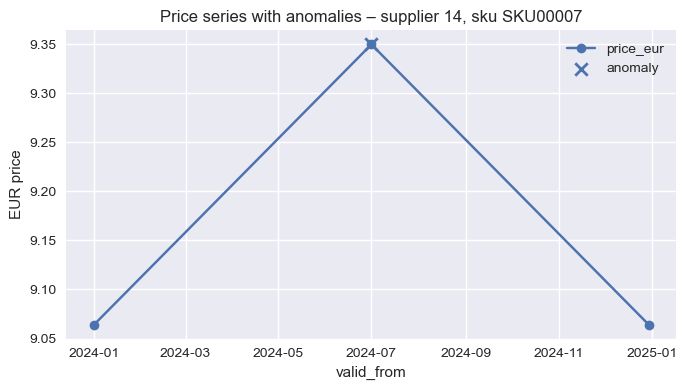

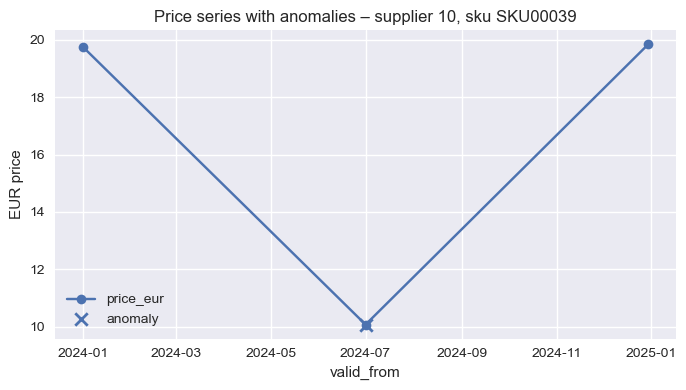

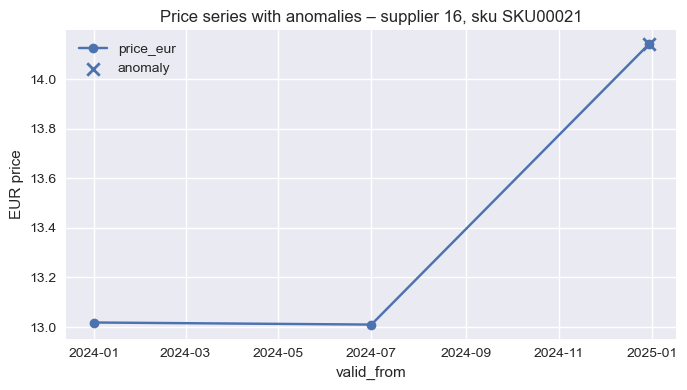

In [30]:
# Small plots (2–3) with flagged points 
def plot_series_with_anoms(df_series, title):
    # df_series: subset for a single (supplier_id, sku)
    plt.figure(figsize=(7,4))
    plt.plot(df_series['valid_from'], df_series['price_eur'], marker='o', label='price_eur')
    # highlight anomalies
    a = df_series[df_series['abs_z'] >= Z_THRESHOLD]
    if not a.empty:
        plt.scatter(a['valid_from'], a['price_eur'], s=80, marker='x', linewidths=2, label='anomaly')
    plt.title(title)
    plt.xlabel('valid_from')
    plt.ylabel('EUR price')
    plt.tight_layout()
    plt.legend()
    plt.show()

# Pick up to 3 (supplier_id, sku) pairs with anomalies
pairs = anoms[['supplier_id','sku']].drop_duplicates().head(3).values.tolist()
for sid, sku in pairs:
    g = prices_.query('supplier_id == @sid and sku == @sku').copy()
    plot_series_with_anoms(g, f"Price series with anomalies – supplier {sid}, sku {sku}")


1. Supplier 14, SKU SKU00007

- Prices vary slightly: €9.06 → €9.35 → €9.06.

- The middle price (€9.35) is marked as an anomaly, despite the change being relatively small.

- The abs_z is extremely high (~18885), likely due to a previous calculation issue or extreme outlier scaling.

Interpretation:
This may indicate a data quality problem rather than a real market anomaly. It should be reviewed operationally to confirm the price series consistency.

2. Supplier 10, SKU SKU00039

- Prices fluctuate dramatically: €19.7 → €10.07 → €19.9.

- The middle value (€10.07) is flagged as an anomaly.

- This corresponds to a very high abs_z value (~97.9), indicating this price is far from the expected range.

Interpretation:
A sudden drop in price followed by recovery is unusual. Could be a promotional price, a data entry mistake, or misapplied currency conversion. Needs validation.

3. Supplier 16, SKU SKU00021

- The price starts around €13.0 for the first two periods (Jan–Jul 2024).

- In the last period (Dec 2024 – Jun 2025), the price jumps to €14.14, which is marked as an anomaly.

- This is consistent with your anomaly detection output (abs_z ≈ 87.15), meaning this price deviates extremely from the typical price distribution for this SKU.

Interpretation:
Sudden jump in price; likely a data entry error or a major supplier price change. Operational review needed to confirm if this is legitimate.

In [31]:
# IsolationForest as alternative detector 
from sklearn.ensemble import IsolationForest

def iso_forest_scores(group: pd.DataFrame, random_state=RANDOM_SEED):
    x = np.log1p(group[['price_eur']].values)  # univariate in log space
    if len(x) < 10:
        return pd.Series(np.zeros(len(group)), index=group.index)  # too short: no-op
    iso = IsolationForest(n_estimators=200, contamination='auto', random_state=random_state)
    s = -iso.score_samples(x)  # higher = more anomalous
    return pd.Series(s, index=group.index)

prices_['iso_score'] = prices_.groupby(['supplier_id','sku'], group_keys=False).apply(iso_forest_scores)

# Combine signals (robust-z + isolation) for review
combo = prices_.copy()
combo['rank_signal'] = combo['abs_z'].rank(method='min', ascending=False) + \
                       combo['iso_score'].rank(method='min', ascending=False)
top_combo = combo.sort_values('rank_signal').head(20)
display(top_combo[['supplier_id','sku','valid_from','price_eur','abs_z','iso_score']].head(10))


,supplier_id,sku,valid_from,price_eur,abs_z,iso_score
566,14,SKU00007,2024-07-01,9.350000,18885.960653,0.0
438,10,SKU00039,2024-07-01,10.070000,97.919669,0.0
662,16,SKU00021,2024-12-30,14.140000,87.151302,0.0
85,3,SKU00020,2024-07-01,47.580000,40.402993,0.0
216,6,SKU00005,2024-12-30,17.669725,39.930544,0.0
769,19,SKU00033,2024-01-01,7.330000,34.673032,0.0
431,10,SKU00019,2024-01-01,19.970000,34.464400,0.0
693,17,SKU00022,2024-12-30,17.963303,30.830917,0.0
398,9,SKU00033,2024-12-30,15.040000,30.064060,0.0
816,19,SKU00023,2024-12-30,6.930000,23.431904,0.0


#### Interpretation:

- All the rows have extremely high abs_z values (e.g., 18885, 97.9, 87.1), meaning these prices are far outside the typical range for their respective SKUs.

- The iso_score of 0.0 confirms that, according to the isolation method, these prices are strong anomalies.

- For example, supplier_id 14 for SKU00007 has a price of €9.35 with an abs_z of 18,885 — this is extremely unusual compared to its normal price range, likely indicating a data entry error, mispricing, or outlier market price.

- Operationally, these would be priority alerts for review because the deviation is massive and could have financial impact.

#### Summary:
This output highlights the most extreme price deviations in your dataset. The combination of abs_z and iso_score gives both a statistical and model-based perspective, helping prioritize which anomalies to investigate first.

---------------------------------------------------------------------------------------------------

### Threshold Choice:
I computed robust z-scores for each price entry, which measure how far a price deviates from the typical range while reducing the effect of existing extreme values. I set the anomaly threshold at |z| ≥ 3, a common statistical standard for identifying outliers. This threshold allows us to capture significant deviations such as data entry errors or unusual supplier pricing without flagging normal variation as anomalies.

Example from data:

SKU00007 had a robust z-score of 18885 → extreme outlier, clearly a pricing error.

SKU00004 had z = 0 → normal, no action needed.

### Operational Validation and Review:
Once anomalies are flagged, the alerts would be validated through a structured workflow:

1- Initial Review: Compare flagged prices against historical prices, supplier contracts, and market benchmarks to confirm whether they are actual anomalies.

2- Categorization:

- Critical anomalies: Large deviations that could cause financial impact are reviewed immediately and corrected.

- Moderate anomalies: Smaller deviations are logged and reviewed in batches or communicated with procurement teams for verification.

3- Feedback Loop: Confirmed anomalies are used to refine detection parameters or adjust thresholds, improving future accuracy.

4- Reporting: Periodic reports summarize anomalies and their resolutions, ensuring transparency and enabling proactive decision-making.

This approach ensures that the threshold is both statistically grounded and practically actionable, minimizing false alerts while catching significant pricing issues.